In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

from scipy.signal import savgol_filter

from scipy.io import loadmat, savemat

sns.set_theme(font_scale=1.5)

In [9]:
def KrauseIonization(altitude):
    '''
    altitude in km
    returns ionization in keV
    '''
    r = (-0.03 * altitude + 39.78)/1e3;
    r[altitude > 240] = (-0.03 * 240 + 39.78)/1e3
    r[altitude < 45] = (-0.03 * 45 + 39.78)/1e3

    return r;

def readAndAverage(filename):
    data = pd.read_csv("../spectral_data/" + filename, names=['E']);

    lineNo   = 1000;

    nThreads = int(len(data)/lineNo);
    
    ionResults = np.zeros([1, lineNo]);
    ionVar     = np.zeros([1, lineNo]);
    for i in range(0, nThreads):
        ionResults += data.E[lineNo*i:lineNo*(i+1)]
    
    for i in range(0, nThreads):
        ionVar += (data.E[lineNo*i:lineNo*(i+1)] - ionResults[0,:])**2;
    
    return ionResults.flatten(), np.sqrt(1/(nThreads-1) * ionVar.flatten());

def readAndAverage2D(filename):
    
    Earray = np.round(np.logspace(np.log10(0.250), np.log10(10000), 100), 2)

    data = pd.read_csv("../spectral_data/" + filename, names=Earray);
    
    lineNo   = 1000;
    
    nThreads = int(len(data)/lineNo);
    
    data.fillna(data.mean(), inplace=True)

    results    = np.zeros([lineNo, 100]);
    resultsVar = np.zeros([lineNo, 100]);
    for i in range(0, nThreads):
        results += data.values[lineNo*i:lineNo*(i+1), :]
        
    for i in range(0, nThreads):
        resultsVar += (data.values[lineNo*i:lineNo*(i+1), :] - results)**2

    return results, np.sqrt(1/(nThreads - 1) * resultsVar);
    
h = np.linspace(0, 999, 1000);
Earray = np.round(np.logspace(np.log10(0.250), np.log10(10000), 100), 2)

def plot_spectra(ionResults, EResults, ionVar, Evar):

    plt.figure(figsize=(14,8)); plt.subplot(1,2,1); 
    plt.grid(True, which='both')
    plt.plot(ionResults/KrauseIonization(h), h, label='$\mu$');
    plt.fill_betweenx(h, (ionResults-ionVar)/KrauseIonization(h), 
                         (ionResults+ionVar)/KrauseIonization(h), 
                      alpha=0.5, label='$\pm \sigma$')
    
    plt.xscale('log');
    plt.xlabel('Ionization Rate [cm$^{-3}$ s$^{-1}$]');
    plt.ylabel('Altitude [km]');
    plt.ylim([0, 240]);
    plt.legend()

    X,Y = np.meshgrid(Earray, h);

    ionVar[h < 120] *= 2;
    
    plt.subplot(1,2,2); plt.grid(True, which='both')
    plt.contourf(X, Y, np.log10(EResults));
    plt.colorbar(label='log$_{10}$ Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ keV$^{-1}$]');

    plt.xscale('log');
    plt.xlabel('Energy [keV]');
    plt.ylabel('Altitude [km]');
    plt.ylim([0, 240]);

def plot_altitude_spectra(EResults, Evar):
    plt.figure(figsize=(10,6)); plt.grid(True, which='both');

    startingAlt = 10;
    stepSize    = 5;

    for j in range(0, 4):

        h1 = startingAlt + j*stepSize;
        h2 = startingAlt + stepSize + j*stepSize;

        ave    = np.zeros([1, len(Earray)])
        aveVar = np.zeros([1, len(Earray)])
        for i in range(h1, h2):
            ave += EResults[i, :]
            aveVar += np.sqrt(Evar[i,:])

        plt.errorbar(Earray, savgol_filter(ave[0,:], 7, 2), aveVar[0,:], label='%.0f - %.0f km' % (h1,h2));

    plt.xscale('log');
    plt.yscale('log');
    plt.legend();
    plt.xlabel('Energy [keV]');
    plt.ylabel('Relative Intensity');
    plt.title('Average Spectra with Altitude');
    
    
def plot_altitude_energy_spectra(EResults, Evar):
    plt.figure(figsize=(10,6)); plt.grid(True, which='both');

    windowSize = 10;
    
    for j in [1e1, 1e2, 1e3, 1e4]:
        
        E1 = j;
        E2 = j*windowSize
        
        inds = (Earray > E1) & (Earray < E2);

        ave    = np.mean(EResults[:,inds], axis=1);
        aveVar = np.mean(np.sqrt(Evar[:,inds]), axis=1);
        
        plt.errorbar(h, savgol_filter(ave, 1, 0), yerr=aveVar, label='%.2f - %.1f MeV' % (E1/1e3,E2/1e3));

    plt.yscale('log');
    plt.legend();
    plt.ylabel('f(E) [keV$^{-1}$]');
    plt.xlabel('Altitude [km]');
    plt.title('Average Spectra with Altitude');
    plt.xlim([0, 500]);

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log10


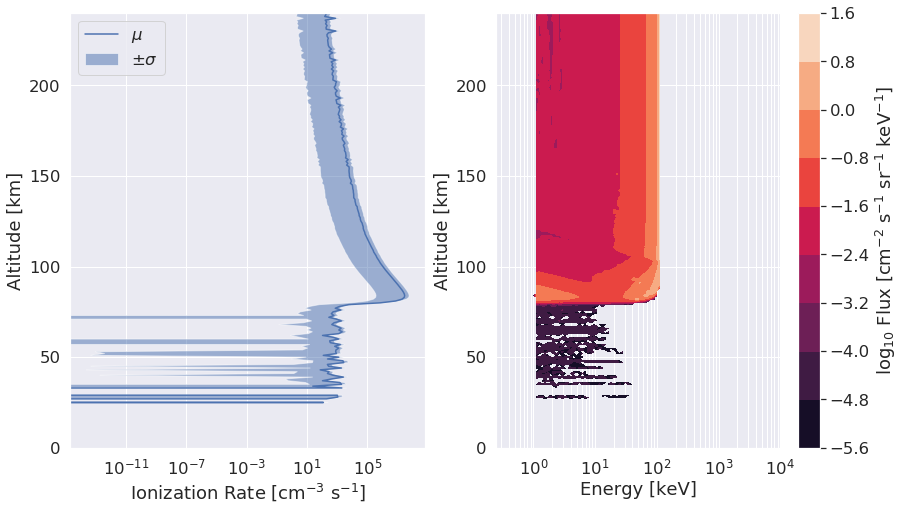

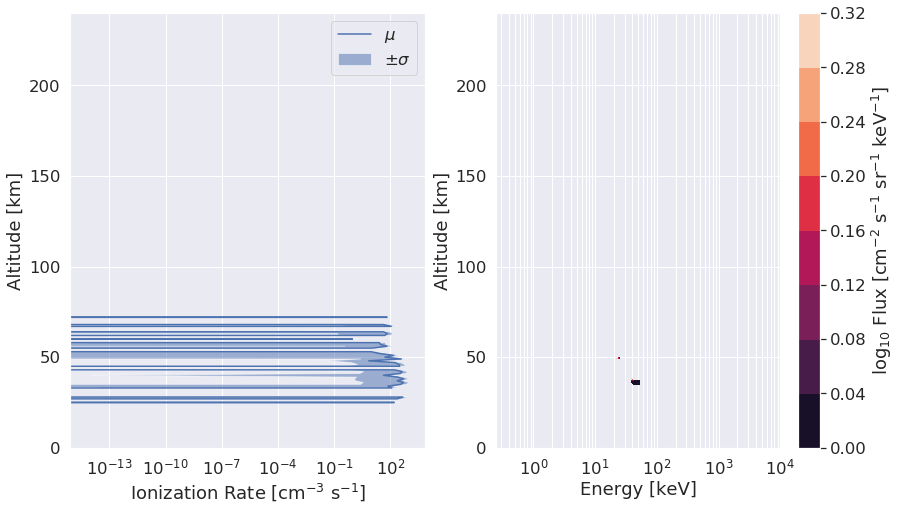

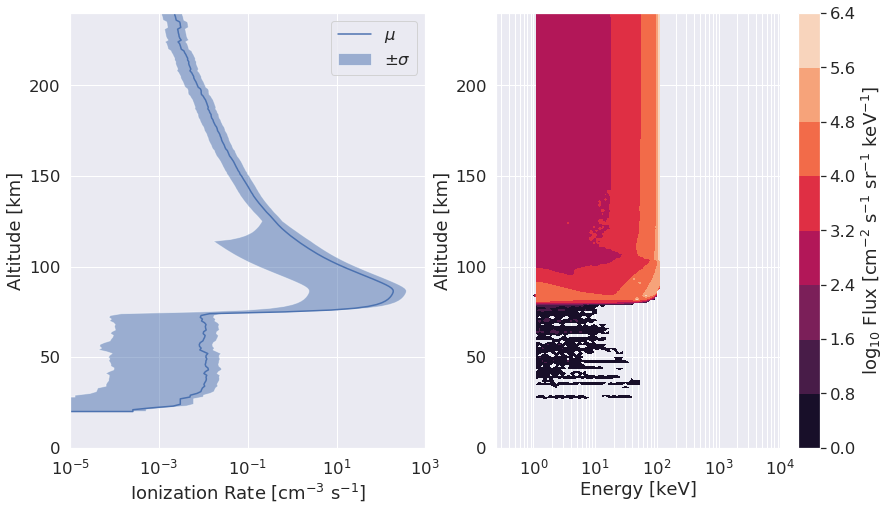

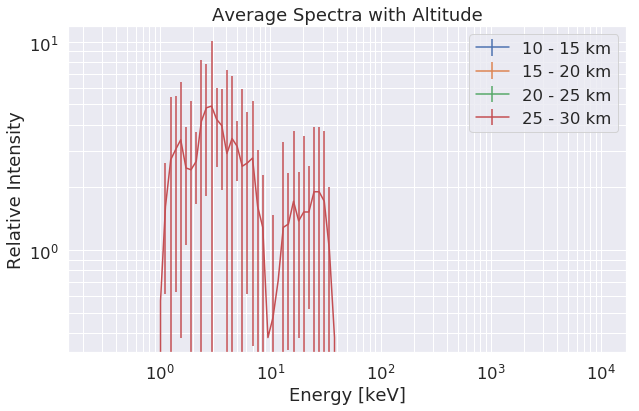

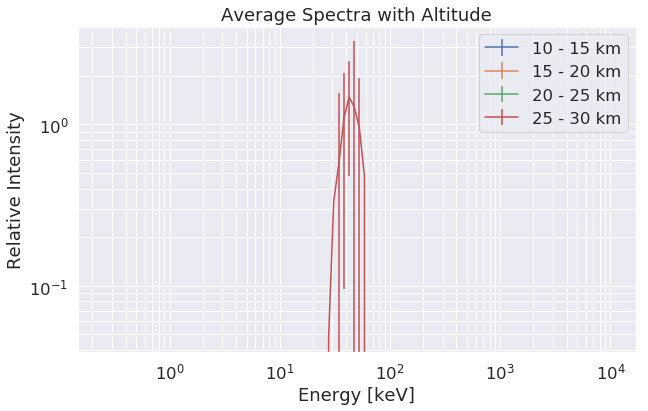

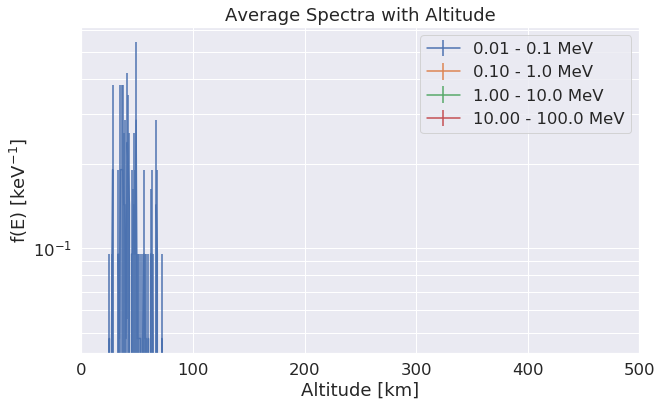

In [10]:
post = '100'

fn1 = "electron_dep_spectra" + post + "keV_iso_1e5.csv";
fn2 = "electron_ene_spectra" + post + "keV_iso_1e5.csv";
fn3 = "photon_dep_spectra" + post + "keV_iso_1e5.csv";
fn4 = "photon_ene_spectra" + post + "keV_iso_1e5.csv";

ionResults, ionVar       = readAndAverage(fn1);
EResults, Evar           = readAndAverage2D(fn2);
ph_ionResults, ph_ionVar = readAndAverage(fn3);
ph_EResults, ph_Evar     = readAndAverage2D(fn4);

saveName = "G4_data/G4_isoPAD_mono" + post + "keV.mat"
savemat(saveName,                   {"electronIonization": ionResults,
                                     "electronIonization_stddev": ionVar,
                                     "electronEnergyDep": EResults, 
                                     "electronEnergyDep_stddev": Evar,
                                     "photonIonization": ph_ionResults,
                                     "photonIonization_stddev": ph_ionVar,
                                     "photonEnergyDep": ph_EResults,
                                     "photonEnergyDep_stddev": ph_Evar})


plot_spectra(ionResults, EResults/1e5, ionVar, Evar);
plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

plot_spectra(savgol_filter(ionResults + ph_ionResults, 11, 1)/1e5, 
             (EResults+ph_EResults), 
             savgol_filter(ionVar+ph_ionVar, 11,1)/2e5, 
             Evar+ph_Evar);

plt.subplot(1,2,1);
plt.xlim(1e-5, 1e3)

plot_altitude_spectra(EResults, Evar);
plot_altitude_spectra(ph_EResults, ph_Evar)

plot_altitude_energy_spectra(ph_EResults, ph_Evar)

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log10


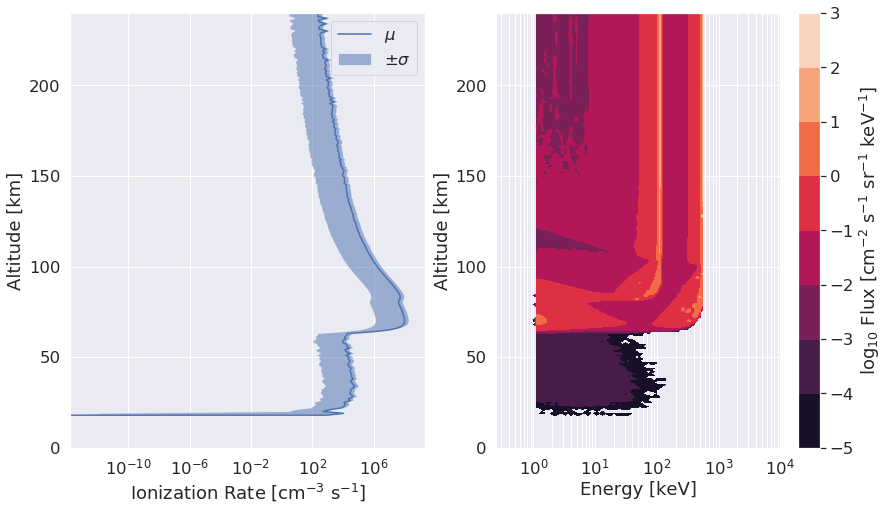

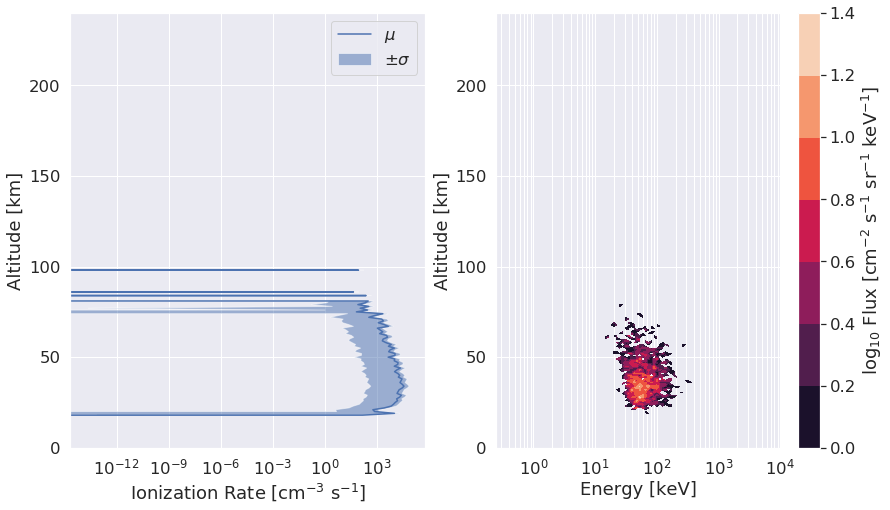

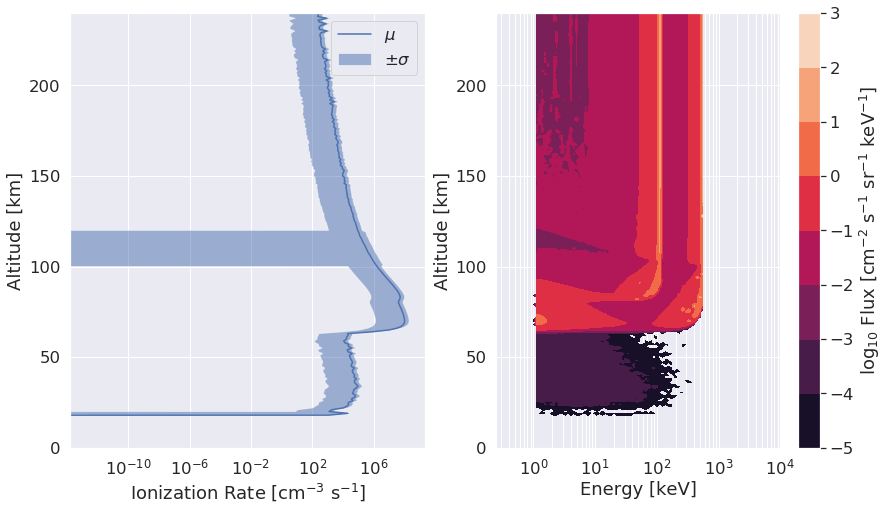

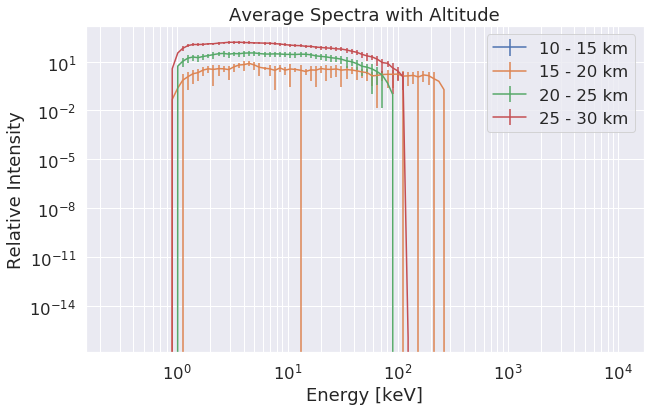

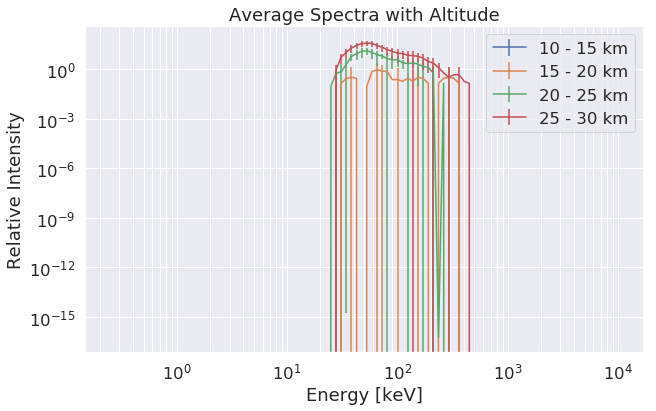

In [4]:
post = '500'

fn1 = "electron_dep_spectra" + post + "keV_iso_1e5.csv";
fn2 = "electron_ene_spectra" + post + "keV_iso_1e5.csv";
fn3 = "photon_dep_spectra" + post   + "keV_iso_1e5.csv";
fn4 = "photon_ene_spectra" + post   + "keV_iso_1e5.csv";

ionResults, ionVar       = readAndAverage(fn1);
EResults, Evar           = readAndAverage2D(fn2);
ph_ionResults, ph_ionVar = readAndAverage(fn3);
ph_EResults, ph_Evar     = readAndAverage2D(fn4);


saveName = "G4_data/G4_isoPAD_mono" + post + "keV.mat"
savemat(saveName,                   {"electronIonization": ionResults,
                                     "electronIonization_stddev": ionVar,
                                     "electronEnergyDep": EResults, 
                                     "electronEnergyDep_stddev": Evar,
                                     "photonIonization": ph_ionResults,
                                     "photonIonization_stddev": ph_ionVar,
                                     "photonEnergyDep": ph_EResults,
                                     "photonEnergyDep_stddev": ph_Evar})

plot_spectra(ionResults, EResults/1e5, ionVar, Evar);
plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

plot_spectra(ionResults + ph_ionResults, (EResults+ph_EResults)/1e5, ionVar+ph_ionVar, Evar+ph_Evar);


plot_altitude_spectra(EResults, Evar);
plot_altitude_spectra(ph_EResults, ph_Evar)

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log10


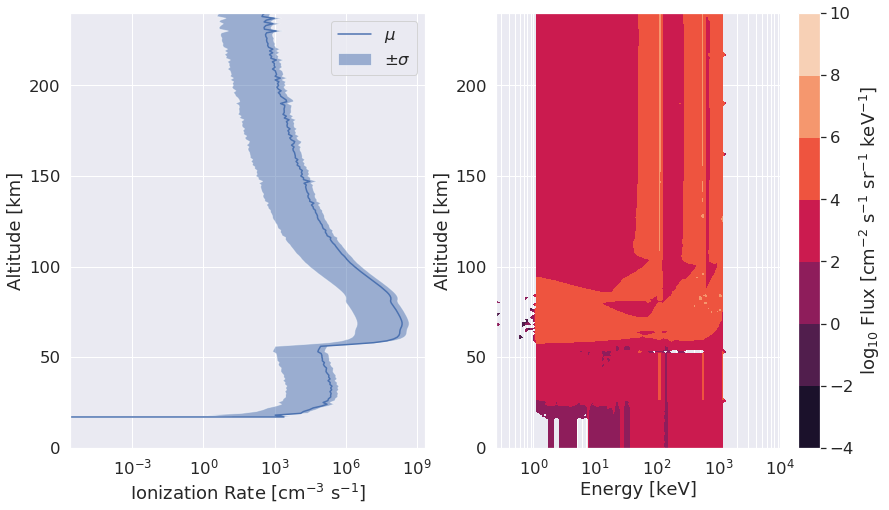

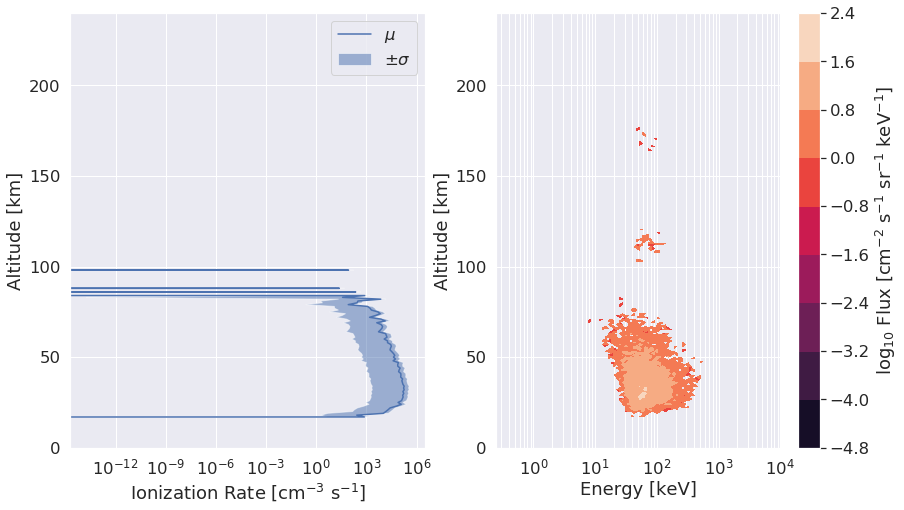

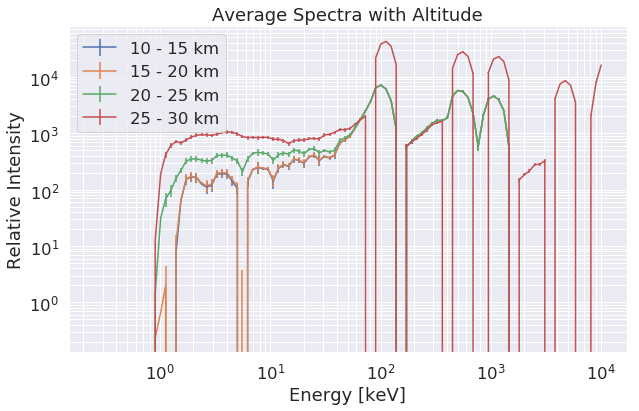

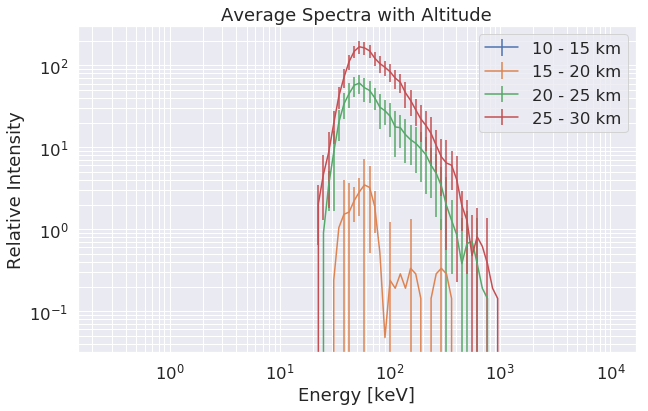

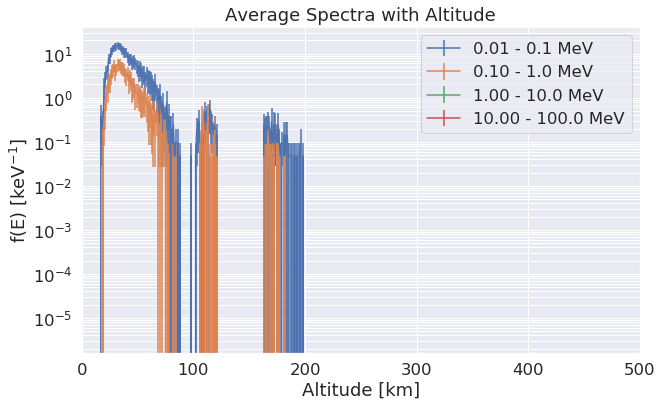

In [5]:
post = '1000'

fn1 = "electron_dep_spectra" + post + "keV_iso_1e5.csv";
fn2 = "electron_ene_spectra" + post + "keV_iso_1e5.csv";
fn3 = "photon_dep_spectra" + post   + "keV_iso_1e5.csv";
fn4 = "photon_ene_spectra" + post   + "keV_iso_1e5.csv";

ionResults, ionVar       = readAndAverage(fn1);
EResults, Evar           = readAndAverage2D(fn2);
ph_ionResults, ph_ionVar = readAndAverage(fn3);
ph_EResults, ph_Evar     = readAndAverage2D(fn4);

saveName = "G4_data/G4_isoPAD_mono" + post + "keV.mat"
savemat(saveName,                   {"electronIonization": ionResults,
                                     "electronIonization_stddev": ionVar,
                                     "electronEnergyDep": EResults, 
                                     "electronEnergyDep_stddev": Evar,
                                     "photonIonization": ph_ionResults,
                                     "photonIonization_stddev": ph_ionVar,
                                     "photonEnergyDep": ph_EResults,
                                     "photonEnergyDep_stddev": ph_Evar})

plot_spectra(ionResults, EResults, ionVar, Evar);
plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

plot_altitude_spectra(EResults, Evar);
plot_altitude_spectra(ph_EResults, ph_Evar)

plot_altitude_energy_spectra(ph_EResults, ph_Evar);

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log10
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


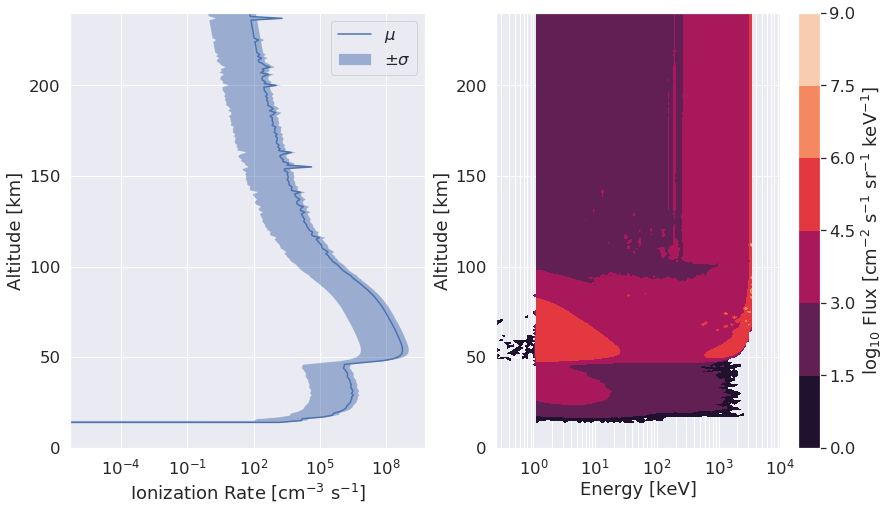

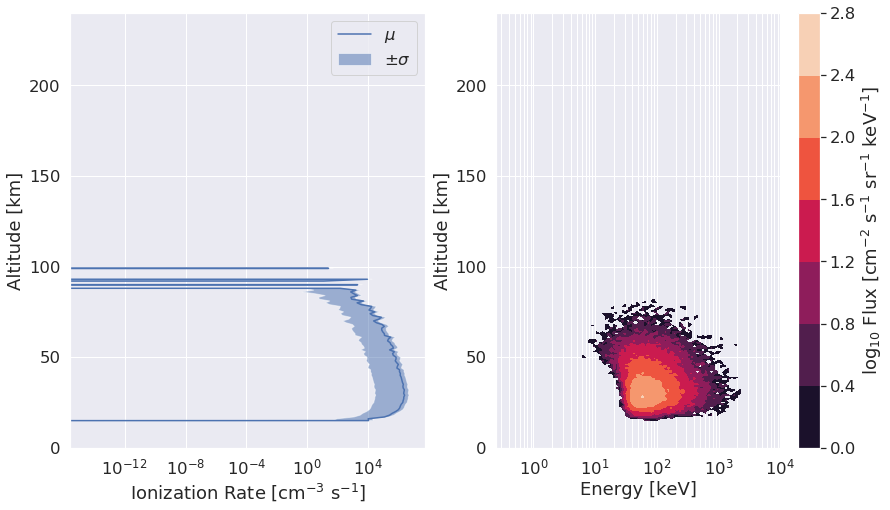

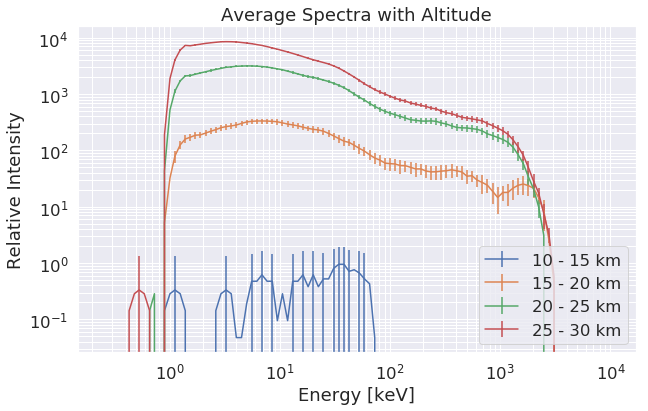

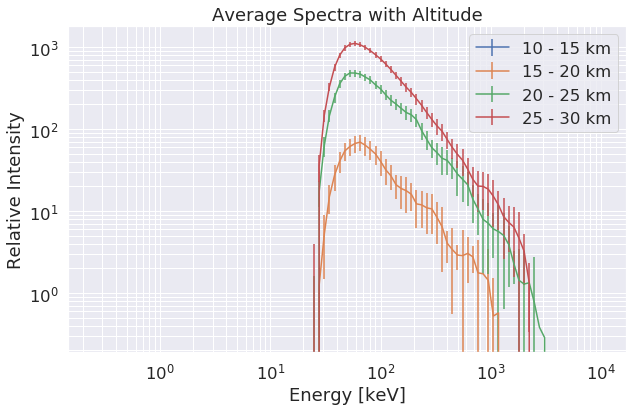

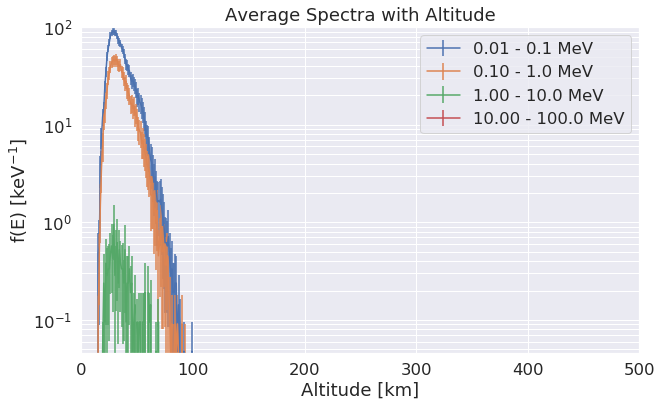

In [6]:
post = '3000'

fn1 = "electron_dep_spectra" + post + "keV_iso_1e5.csv";
fn2 = "electron_ene_spectra" + post + "keV_iso_1e5.csv";
fn3 = "photon_dep_spectra" + post   + "keV_iso_1e5.csv";
fn4 = "photon_ene_spectra" + post   + "keV_iso_1e5.csv";

ionResults, ionVar       = readAndAverage(fn1);
EResults, Evar           = readAndAverage2D(fn2);
ph_ionResults, ph_ionVar = readAndAverage(fn3);
ph_EResults, ph_Evar     = readAndAverage2D(fn4);

saveName = "G4_data/G4_isoPAD_mono" + post + "keV.mat"
savemat(saveName,                   {"electronIonization": ionResults,
                                     "electronIonization_stddev": ionVar,
                                     "electronEnergyDep": EResults, 
                                     "electronEnergyDep_stddev": Evar,
                                     "photonIonization": ph_ionResults,
                                     "photonIonization_stddev": ph_ionVar,
                                     "photonEnergyDep": ph_EResults,
                                     "photonEnergyDep_stddev": ph_Evar})

plot_spectra(ionResults, EResults, ionVar, Evar);
plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

plot_altitude_spectra(EResults, Evar);
plot_altitude_spectra(ph_EResults, ph_Evar)

plot_altitude_energy_spectra(ph_EResults, ph_Evar);
plt.ylim([0,100]);

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log10


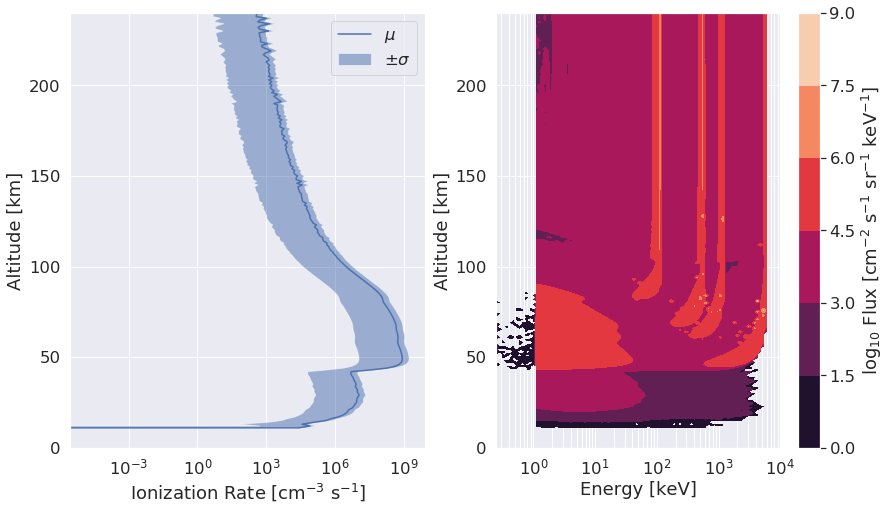

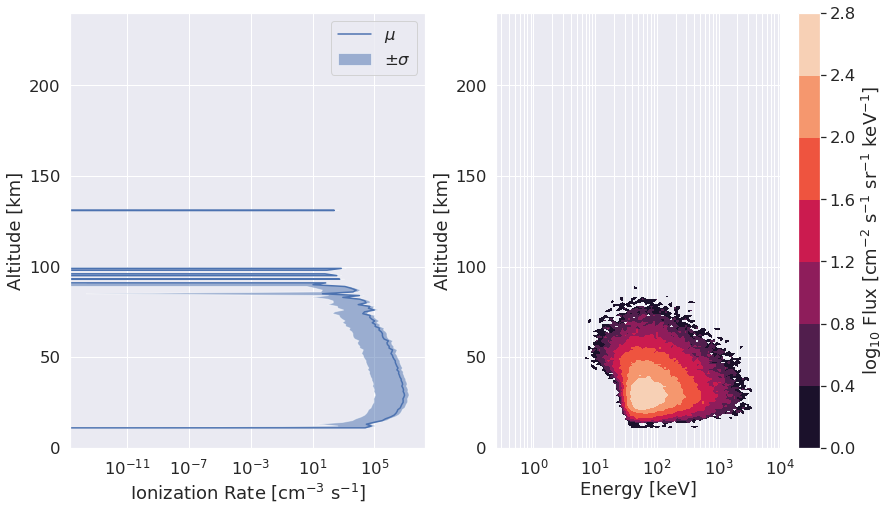

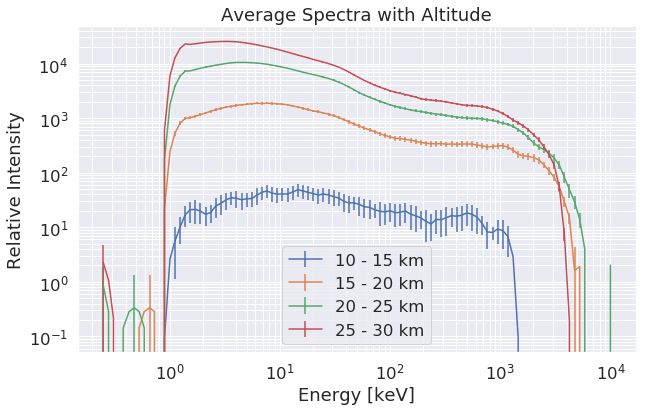

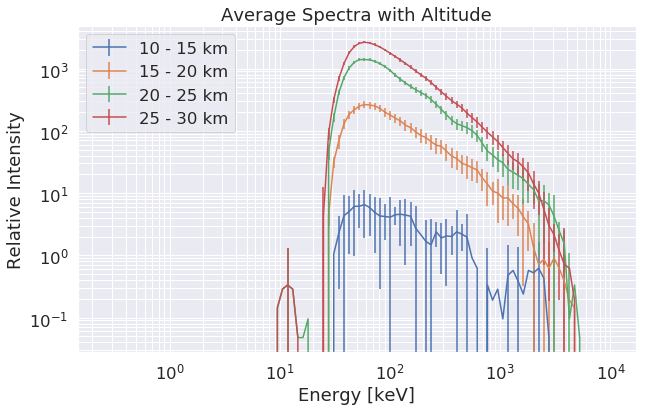

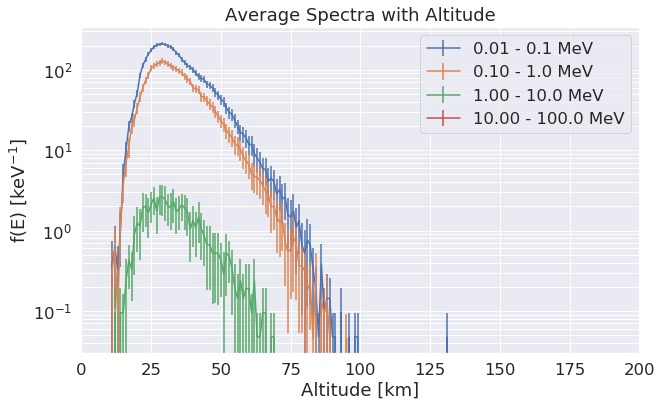

In [7]:
post = '5000'

fn1 = "electron_dep_spectra" + post + "keV_iso_1e5.csv";
fn2 = "electron_ene_spectra" + post + "keV_iso_1e5.csv";
fn3 = "photon_dep_spectra" + post   + "keV_iso_1e5.csv";
fn4 = "photon_ene_spectra" + post   + "keV_iso_1e5.csv";

ionResults, ionVar       = readAndAverage(fn1);
EResults, Evar           = readAndAverage2D(fn2);
ph_ionResults, ph_ionVar = readAndAverage(fn3);
ph_EResults, ph_Evar     = readAndAverage2D(fn4);

saveName = "G4_data/G4_isoPAD_mono" + post + "keV.mat"
savemat(saveName,                   {"electronIonization": ionResults,
                                     "electronIonization_stddev": ionVar,
                                     "electronEnergyDep": EResults, 
                                     "electronEnergyDep_stddev": Evar,
                                     "photonIonization": ph_ionResults,
                                     "photonIonization_stddev": ph_ionVar,
                                     "photonEnergyDep": ph_EResults,
                                     "photonEnergyDep_stddev": ph_Evar})

plot_spectra(ionResults, EResults, ionVar, Evar);
plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

plot_altitude_spectra(EResults, Evar);
plot_altitude_spectra(ph_EResults, ph_Evar)

plot_altitude_energy_spectra(ph_EResults, ph_Evar);
plt.xlim(0,200);

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log10


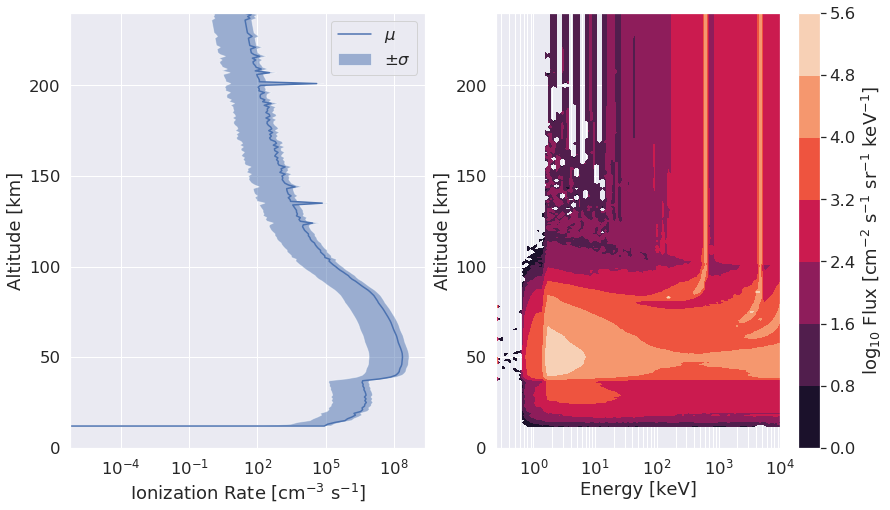

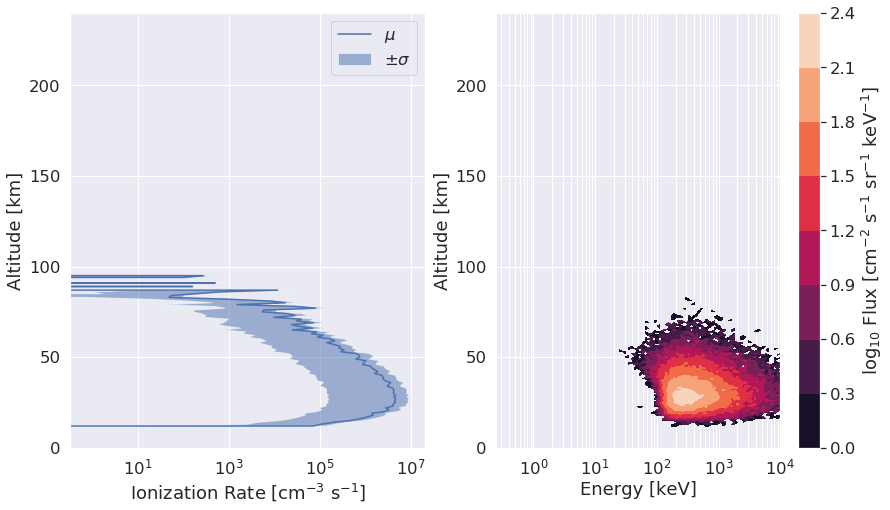

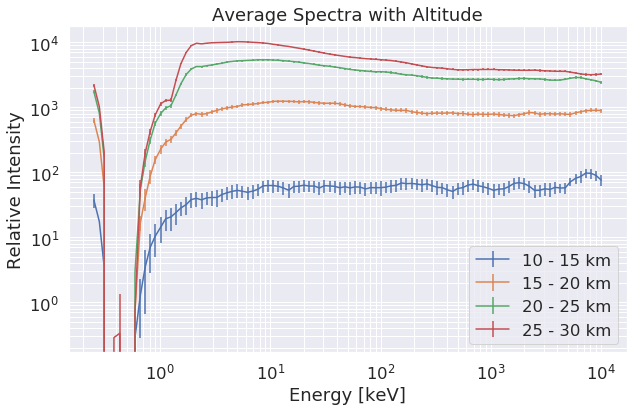

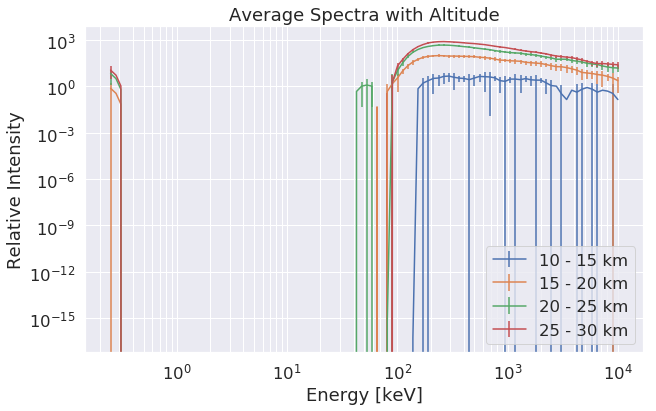

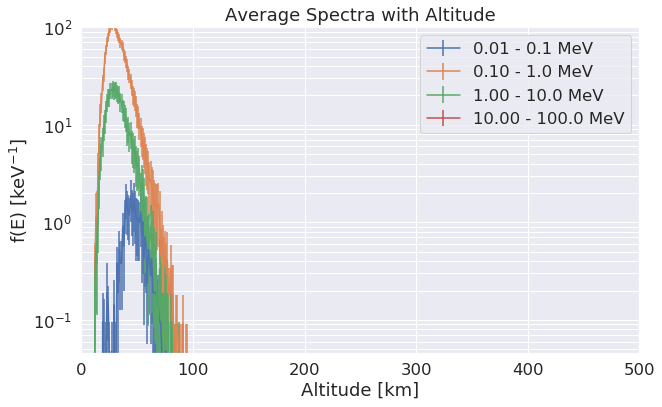

In [8]:
post = '10000'

fn1 = "electron_dep_spectra" + post + "keV_iso.csv";
fn2 = "electron_ene_spectra" + post + "keV_iso.csv";
fn3 = "photon_dep_spectra" + post + "keV_iso.csv";
fn4 = "photon_ene_spectra" + post + "keV_iso.csv";

ionResults, ionVar       = readAndAverage(fn1);
EResults, Evar           = readAndAverage2D(fn2);
ph_ionResults, ph_ionVar = readAndAverage(fn3);
ph_EResults, ph_Evar     = readAndAverage2D(fn4);

saveName = "G4_data/G4_isoPAD_mono" + post + "keV.mat"
savemat(saveName,                   {"electronIonization": ionResults,
                                     "electronIonization_stddev": ionVar,
                                     "electronEnergyDep": EResults, 
                                     "electronEnergyDep_stddev": Evar,
                                     "photonIonization": ph_ionResults,
                                     "photonIonization_stddev": ph_ionVar,
                                     "photonEnergyDep": ph_EResults,
                                     "photonEnergyDep_stddev": ph_Evar})

plot_spectra(ionResults, EResults, ionVar, Evar);
plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

plot_altitude_spectra(EResults, Evar);
plot_altitude_spectra(ph_EResults, ph_Evar)

plot_altitude_energy_spectra(ph_EResults, ph_Evar);
plt.ylim(0, 100);